In [ ]:
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
import tensorflow as tf
seed_val = 42

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.1MB 9.2MB/s 
     |████████████████████████████████| 3.3MB 21.4MB/s 
     |████████████████████████████████| 901kB 60.4MB/s 


In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
import pickle
from sklearn.model_selection import train_test_split

In [ ]:
import random
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
tf.random.set_seed(seed_val)

In [ ]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")
y["cat"] = y.target.astype("category")
y["codes"] = y["cat"].cat.codes
labels = y["codes"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0, stratify = labels)

In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(len(X_train)))
print('Number of testing sentences: {:,}\n'.format(len(X_test)))

# Display 10 random rows from the data.
print(X_train.iloc[0])

Number of training sentences: 807

Number of testing sentences: 202

salary_type                                                Yearly
company                                                     Jobot
title                                   Technical Product Manager
description     Technical Product Manager - Owner, C++ or Pyth...
living_index                                                93.35
Name: 834, dtype: object


In [ ]:
#df_train.loc[df_train.label == 0].sample(5)[['sentence', 'label']]

In [ ]:
sentences = [d.salary_type + " " + str(d.living_index) + " "  + d.company + " " + d.title + " " + d.description for i, d in X_train.iterrows()]
labels = [d for d in y_train]

In [ ]:
from transformers import BertTokenizer

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Yearly 93.35 Jobot Technical Product Manager Technical Product Manager - Owner, C++ or Python, API and/or SDK - Salary (DOE)

This Jobot Job is hosted by: Nathan Duong
Are you a fit? Easy Apply now by clicking the "Apply On Company Site" button and sending us your resume.
Salary: $140,000 - $170,000

A bit about us:
---------

Based near Redwood City, CA, we are the world's leading data analytics company that is revolutionizing the world with our full-service platform. We are a publicly-traded company with some of the biggest reputable investors. We help companies take their data and turn it into rich and useful information that our clients have used and thrust their way to the top!!! Just to give you some insight. We went from 600 - 1500 employees in one year, and we are planning to double in size by next!!! Due to exponentially rapid growth, we're looking for a solid and experienced Technical Project Manager to join the team.

This candidate should have a strong understan

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = 300,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Yearly 93.35 Jobot Technical Product Manager Technical Product Manager - Owner, C++ or Python, API and/or SDK - Salary (DOE)

This Jobot Job is hosted by: Nathan Duong
Are you a fit? Easy Apply now by clicking the "Apply On Company Site" button and sending us your resume.
Salary: $140,000 - $170,000

A bit about us:
---------

Based near Redwood City, CA, we are the world's leading data analytics company that is revolutionizing the world with our full-service platform. We are a publicly-traded company with some of the biggest reputable investors. We help companies take their data and turn it into rich and useful information that our clients have used and thrust their way to the top!!! Just to give you some insight. We went from 600 - 1500 employees in one year, and we are planning to double in size by next!!! Due to exponentially rapid growth, we're looking for a solid and experienced Technical Project Manager to join the team.

This candidate should have a strong understand

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  300


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. These can be quite long
MAX_LEN = 300

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 300 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

In [ ]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16
# batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import RobertaForSequenceClassification, BertForSequenceClassification, AdamW, BertConfig

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  # lr = 2e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# epochs = 6

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     41.    Elapsed: 0:00:34.

  Average training loss: 1.60
  Training epoch took: 0:00:35

Running Validation...
  Accuracy: 0.32
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     41.    Elapsed: 0:00:37.

  Average training loss: 1.52
  Training epoch took: 0:00:37

Running Validation...
  Accuracy: 0.32
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     41.    Elapsed: 0:00:37.

  Average training loss: 1.37
  Training epoch took: 0:00:37

Running Validation...
  Accuracy: 0.36
  Validation took: 0:00:03

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     41.    Elapsed: 0:00:37.

  Average training loss: 1.24
  Training epoch took: 0:00:37

Running Validation...
  Accuracy: 0.36
  Validation took: 0:00:03

Training complete!


In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

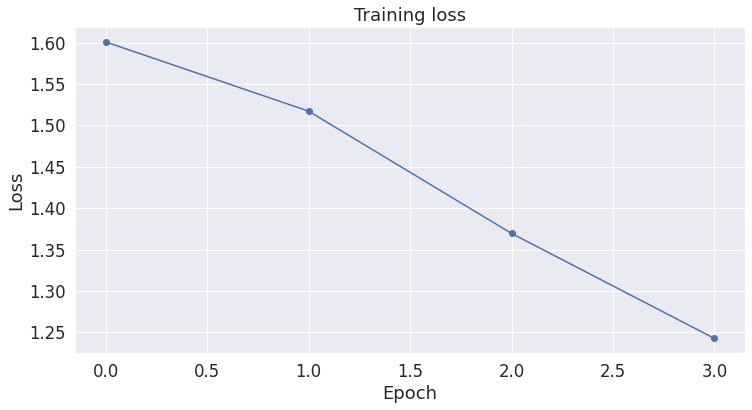

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# TESTING

In [ ]:
# Put model in evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Report the number of sentences.
# print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
# sentences = df_test.sentence.values
# labels = df_test.label.values
# sentences = [d[0] for d in df_test]
# labels = [int(d[1]) for d in df_test]
sentences = [d.salary_type + " " + str(d.living_index) + " "  + d.company + " " + d.title + " " + d.description for i, d in X_test.iterrows()]
labels = [d for d in y_test]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


In [ ]:

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
TEST_PREDICTION_VALUES = []
TEST_TRUTH_VALUES = []
for i in range(len(predictions)):
  this_batch_predictions = np.argmax(predictions[i], axis=1).flatten()
  TEST_PREDICTION_VALUES.extend(this_batch_predictions)
  TEST_TRUTH_VALUES.extend(true_labels[i])


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
mapping = {
    3:"120K - 150K",
    1:"60K - 90K",
    2:"90K - 120K",
    0:"<60K",
    4:">150K",
}
tt = [mapping[t] for t in TEST_TRUTH_VALUES]
tp = [mapping[t] for t in TEST_PREDICTION_VALUES]

In [ ]:
print(classification_report(tt, tp))

              precision    recall  f1-score   support

 120K - 150K       0.55      0.49      0.52        45
   60K - 90K       0.25      0.20      0.22        41
  90K - 120K       0.00      0.00      0.00        31
        <60K       0.33      0.57      0.42        47
       >150K       0.44      0.55      0.49        38

    accuracy                           0.39       202
   macro avg       0.31      0.36      0.33       202
weighted avg       0.33      0.39      0.35       202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(TEST_TRUTH_VALUES, TEST_PREDICTION_VALUES))

              precision    recall  f1-score   support

           0       0.33      0.57      0.42        47
           1       0.25      0.20      0.22        41
           2       0.00      0.00      0.00        31
           3       0.55      0.49      0.52        45
           4       0.44      0.55      0.49        38

    accuracy                           0.39       202
   macro avg       0.31      0.36      0.33       202
weighted avg       0.33      0.39      0.35       202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc

In [ ]:
accuracy_score(TEST_TRUTH_VALUES, TEST_PREDICTION_VALUES)

0.38613861386138615